In [3]:
# ---------------------- سلول ۱: نصب و ایمپورت کتابخانه‌ها ----------------------
# اگر از Google Colab استفاده می‌کنید و این پکیج‌ها نصب نیستند، خط زیر را اجرا کنید.
# !pip install torch torchvision numpy scikit-learn matplotlib seaborn albumentations opencv-python tqdm

import os
import random
import json
from glob import glob
from collections import defaultdict
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [13]:
# ---------------------- سلول ۲: توابع و کلاس‌ها ----------------------
losses = []
def prepare_dataset_paths(train_dir, val_dir, split_ratio=0.66, output_json='dataset_paths.json'):
    all_train_classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
    random.shuffle(all_train_classes)

    num_known = int(len(all_train_classes) * split_ratio)
    known_classes = all_train_classes[:num_known]
    unknown_classes = all_train_classes[num_known:]

    dataset_paths = {
        'known_train': [],
        'known_val': [],
        'unknown_val': [],
        'known_classes': known_classes,
        'unknown_classes': unknown_classes,
        'detected_val_classes': []
    }

    for cls in known_classes:
        cls_path = os.path.join(train_dir, cls)
        images = glob(os.path.join(cls_path, '*'))
        dataset_paths['known_train'].extend(images)

    val_classes = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])
    dataset_paths['detected_val_classes'] = val_classes

    for cls in val_classes:
        cls_path = os.path.join(val_dir, cls)
        images = glob(os.path.join(cls_path, '*'))
        if cls in known_classes:
            dataset_paths['known_val'].extend(images)
        elif cls in unknown_classes:
            dataset_paths['unknown_val'].extend(images)
        else:
            print(f"⚠️ کلاس '{cls}' در val وجود دارد ولی نه در known و نه در unknown.")

    overlap = set(known_classes).intersection(set(unknown_classes))
    if overlap:
        print("❌ کلاس‌های مشترک بین known و unknown:", overlap)
    else:
        print("✅ هیچ اشتراکی بین known و unknown وجود ندارد.")

    with open(output_json, 'w') as f:
        json.dump(dataset_paths, f, indent=2)

    print(f"✅ مسیر تصاویر آماده شد و در '{output_json}' ذخیره شد.")

class Encoder(nn.Module):
    def __init__(self, embedding_dim=128, fine_tune_backbone=True):
        super(Encoder, self).__init__()
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.backbone = resnet50(weights=weights)
        self.backbone = torch.nn.Sequential(*list(self.backbone.children())[:-1])
        if not fine_tune_backbone:
             for param in self.backbone.parameters():
                 param.requires_grad = False
        self.embedding_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, embedding_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding_head(x)
        return x

class FeatureDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"تصویر پیدا نشد: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

def group_images_by_class(image_paths):
    class_to_images = defaultdict(list)
    for path in image_paths:
        cls = os.path.basename(os.path.dirname(path))
        class_to_images[cls].append(path)
    return class_to_images

class ContrastiveDataset(Dataset):
    def __init__(self, class_to_images, transform=None, num_pairs_per_class=10):
        self.pairs = []
        self.labels = []
        self.transform = transform
        self.class_to_images = class_to_images
        classes = list(class_to_images.keys())

        print("✅ در حال ساخت جفت‌های داده...")
        for cls in tqdm(classes, desc="جفت‌های مثبت"):
            imgs = self.class_to_images[cls]
            if len(imgs) < 2:
                continue
            for _ in range(num_pairs_per_class):
                img1_path, img2_path = random.sample(imgs, 2)
                self.pairs.append((img1_path, img2_path))
                self.labels.append(1)

        num_negative_pairs = len(self.pairs)
        for _ in tqdm(range(num_negative_pairs), desc="جفت‌های منفی"):
            cls1, cls2 = random.sample(classes, 2)
            img1_path = random.choice(self.class_to_images[cls1])
            img2_path = random.choice(self.class_to_images[cls2])
            self.pairs.append((img1_path, img2_path))
            self.labels.append(0)

    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        path1, path2 = self.pairs[idx]
        label = self.labels[idx]
        img1 = cv2.imread(path1)
        img2 = cv2.imread(path2)
        if img1 is None or img2 is None:
            raise ValueError(f"تصویر خراب: {path1} یا {path2}")
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        if self.transform:
            img1 = self.transform(image=img1)['image']
            img2 = self.transform(image=img2)['image']
        return img1, img2, torch.tensor(label, dtype=torch.float32)

def contrastive_loss(embedding1, embedding2, label, margin=1.0):
    distance = F.pairwise_distance(embedding1, embedding2)
    loss = label * torch.pow(distance, 2) + \
           (1 - label) * torch.pow(torch.clamp(margin - distance, min=0.0), 2)
    return loss.mean()

def train_encoder_contrastive_with_checkpoint(model, dataloader, optimizer,
                                              epochs=1,
                                              checkpoint_path="/content/drive/MyDrive/checkpoints/encoder_checkpoint_resnet.pth"):
    os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print("🟡 Checkpoint موجود است، در حال بارگذاری...")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ ادامه آموزش از epoch {start_epoch}")

    model.train()
    for epoch in range(start_epoch, epochs):
        total_loss = 0.0
        for img1, img2, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            img1, img2, labels = img1.to(DEVICE), img2.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            emb1 = model(img1)
            emb2 = model(img2)
            loss = contrastive_loss(emb1, emb2, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")
        losses.append(avg_loss)

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)
        print(f"💾 Checkpoint ذخیره شد: {checkpoint_path}")

    print("🎉 آموزش کامل شد.")

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for images in tqdm(dataloader, desc="Extracting Embeddings"):
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu())
    embeddings = torch.cat(embeddings).numpy()
    return embeddings

In [14]:
# ---------------------- سلول ۳: آماده‌سازی و تعریف داده‌ها ----------------------
prepare_dataset_paths(
    train_dir="/content/drive/MyDrive/train",
    val_dir="/content/drive/MyDrive/val",
    output_json='/content/drive/MyDrive/dataset_paths.json'
)

IMG_SIZE = 128
transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

with open('/content/drive/MyDrive/dataset_paths.json', 'r') as f:
    paths = json.load(f)

known_train_paths = paths['known_train']
class_to_images = group_images_by_class(known_train_paths)
contrastive_dataset = ContrastiveDataset(class_to_images, transform=transform, num_pairs_per_class=20)
contrastive_loader = DataLoader(contrastive_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

✅ هیچ اشتراکی بین known و unknown وجود ندارد.
✅ مسیر تصاویر آماده شد و در '/content/drive/MyDrive/dataset_paths.json' ذخیره شد.
✅ در حال ساخت جفت‌های داده...


جفت‌های منفی: 100%|██████████| 3520/3520 [00:00<00:00, 340512.71it/s]


In [24]:
# ---------------------- سلول ۴: آموزش مدل ----------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ DEVICE = {DEVICE}")

encoder = Encoder(embedding_dim=128, fine_tune_backbone=True).to(DEVICE)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)

train_encoder_contrastive_with_checkpoint(
    encoder,
    contrastive_loader,
    optimizer,
    epochs=20,
    checkpoint_path="/content/drive/MyDrive/checkpoints/encoder_checkpoint_resnet.pth"
)

✅ DEVICE = cuda
🟡 Checkpoint موجود است، در حال بارگذاری...
✅ ادامه آموزش از epoch 16


Epoch 17/20: 100%|██████████| 110/110 [02:05<00:00,  1.15s/it]


Epoch 17 - Loss: 0.0171
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint_resnet.pth


Epoch 18/20: 100%|██████████| 110/110 [02:10<00:00,  1.19s/it]


Epoch 18 - Loss: 0.0178
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint_resnet.pth


Epoch 19/20: 100%|██████████| 110/110 [02:12<00:00,  1.20s/it]


Epoch 19 - Loss: 0.0157
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint_resnet.pth


Epoch 20/20: 100%|██████████| 110/110 [02:09<00:00,  1.18s/it]


Epoch 20 - Loss: 0.0151
💾 Checkpoint ذخیره شد: /content/drive/MyDrive/checkpoints/encoder_checkpoint_resnet.pth
🎉 آموزش کامل شد.


In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

NameError: name 'losses' is not defined

<Figure size 1000x600 with 0 Axes>


🚀 در حال استخراج Embeddingها...


Extracting Embeddings: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]



✅ در حال آموزش NearestNeighbors روی مجموعه آموزشی...


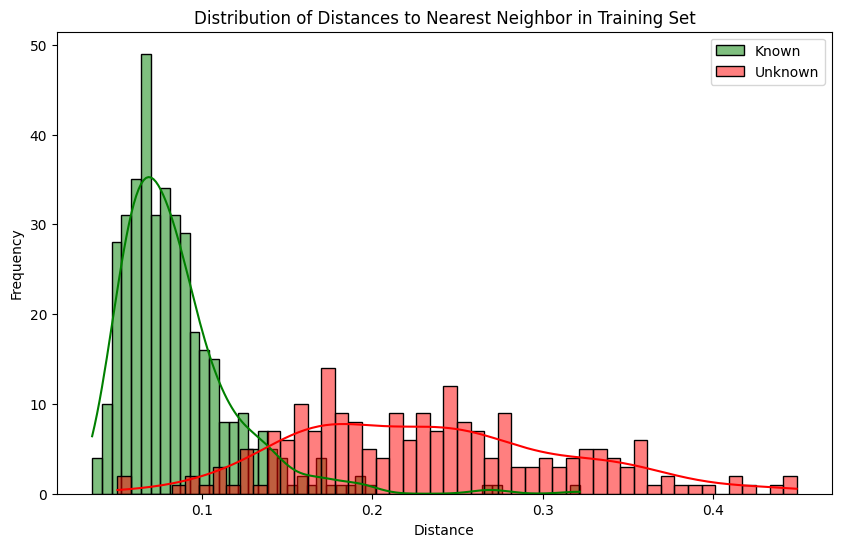


ROC AUC: 0.9688
بهترین threshold بر اساس F1 score: 0.1413
              precision    recall  f1-score   support

       Known       0.95      0.95      0.95       394
     Unknown       0.90      0.91      0.90       209

    accuracy                           0.93       603
   macro avg       0.93      0.93      0.93       603
weighted avg       0.93      0.93      0.93       603


📊 Confusion Matrix:


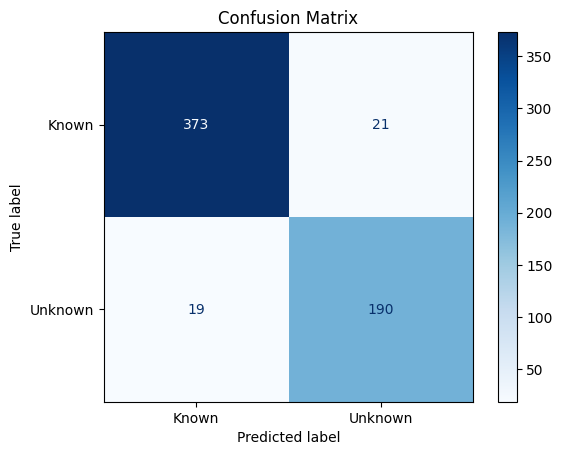

In [26]:
# ---------------------- سلول ۵: ارزیابی مدل ----------------------
known_val_paths = paths['known_val']
unknown_val_paths = paths['unknown_val']
known_train_dataset = FeatureDataset(known_train_paths, transform=transform)
known_val_dataset = FeatureDataset(known_val_paths, transform=transform)
unknown_val_dataset = FeatureDataset(unknown_val_paths, transform=transform)
known_train_loader = DataLoader(known_train_dataset, batch_size=64, shuffle=False)
known_val_loader = DataLoader(known_val_dataset, batch_size=64, shuffle=False)
unknown_val_loader = DataLoader(unknown_val_dataset, batch_size=64, shuffle=False)

print("\n🚀 در حال استخراج Embeddingها...")
known_train_emb = extract_embeddings(encoder, known_train_loader, DEVICE)
known_val_emb = extract_embeddings(encoder, known_val_loader, DEVICE)
unknown_val_emb = extract_embeddings(encoder, unknown_val_loader, DEVICE)

print("\n✅ در حال آموزش NearestNeighbors روی مجموعه آموزشی...")
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(known_train_emb)
dist_known_val, _ = nbrs.kneighbors(known_val_emb)
dist_known_val = dist_known_val.flatten()
dist_unknown_val, _ = nbrs.kneighbors(unknown_val_emb)
dist_unknown_val = dist_unknown_val.flatten()

plt.figure(figsize=(10, 6))
sns.histplot(dist_known_val, color='green', label='Known', kde=True, bins=50)
sns.histplot(dist_unknown_val, color='red', label='Unknown', kde=True, bins=50)
plt.title('Distribution of Distances to Nearest Neighbor in Training Set')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('distance_histogram.png')
plt.show()

y_true = np.concatenate([np.zeros_like(dist_known_val), np.ones_like(dist_unknown_val)])
y_scores = np.concatenate([dist_known_val, dist_unknown_val])
auc = roc_auc_score(y_true, y_scores)
print(f"\nROC AUC: {auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"بهترین threshold بر اساس F1 score: {best_threshold:.4f}")

y_pred = (y_scores >= best_threshold).astype(int)
print(classification_report(y_true, y_pred, target_names=['Known', 'Unknown']))

print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Known', 'Unknown'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [27]:
test_dir = "/content/drive/MyDrive/test"
test_classes = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])

# فرض کنیم بخوای کلاس‌های تست رو بر اساس known و unknown که از قبل داری جدا کنی:
known_classes = paths['known_classes']  # از JSON بارگذاری کردی
unknown_classes = paths['unknown_classes']

known_test_paths = []
unknown_test_paths = []

for cls in test_classes:
    cls_path = os.path.join(test_dir, cls)
    images = glob(os.path.join(cls_path, '*'))
    if cls in known_classes:
        known_test_paths.extend(images)
    elif cls in unknown_classes:
        unknown_test_paths.extend(images)
    else:
        print(f"کلاس {cls} در known یا unknown نیست.")

In [28]:
import pandas as pd
from tqdm import tqdm

# ترکیب مسیرها و برچسب‌های واقعی
all_test_paths = known_test_paths + unknown_test_paths
true_labels = [0] * len(known_test_paths) + [1] * len(unknown_test_paths)  # 0 = known, 1 = unknown

# ساخت دیتاست تست کامل
full_test_dataset = FeatureDataset(all_test_paths, transform=transform)
full_test_loader = DataLoader(full_test_dataset, batch_size=1, shuffle=False)

# استخراج embedding‌ها
print("🚀 در حال استخراج embedding برای کل مجموعه تست...")
test_embeddings = extract_embeddings(encoder, full_test_loader, DEVICE)

# محاسبه فاصله تا نزدیک‌ترین نمونه از train
print("📏 در حال محاسبه فاصله‌ها از مجموعه train...")
distances, _ = nbrs.kneighbors(test_embeddings)
distances = distances.flatten()

# اعمال threshold
pred_labels = (distances >= best_threshold).astype(int)

# گزارش ردیف به ردیف
results = []
for i, path in enumerate(all_test_paths):
    folder_name = os.path.basename(os.path.dirname(path))
    predicted = "Unknown" if pred_labels[i] == 1 else "Known"
    actual = "Unknown" if true_labels[i] == 1 else "Known"
    correct = "✅" if pred_labels[i] == true_labels[i] else "❌"

    results.append({
        "Image Path": path,
        "Folder Name": folder_name,
        "Actual Class": actual,
        "Predicted Class": predicted,
        "Distance": round(distances[i], 4),
        "Correct?": correct
    })

# ذخیره نتایج به CSV
results_df = pd.DataFrame(results)
csv_path = "/content/drive/MyDrive/test_predictions_detailed.csv"
results_df.to_csv(csv_path, index=False)
print(f"📁 فایل نتایج ذخیره شد: {csv_path}")

🚀 در حال استخراج embedding برای کل مجموعه تست...


Extracting Embeddings: 100%|██████████| 992/992 [00:18<00:00, 54.08it/s]

📏 در حال محاسبه فاصله‌ها از مجموعه train...
📁 فایل نتایج ذخیره شد: /content/drive/MyDrive/test_predictions_detailed.csv


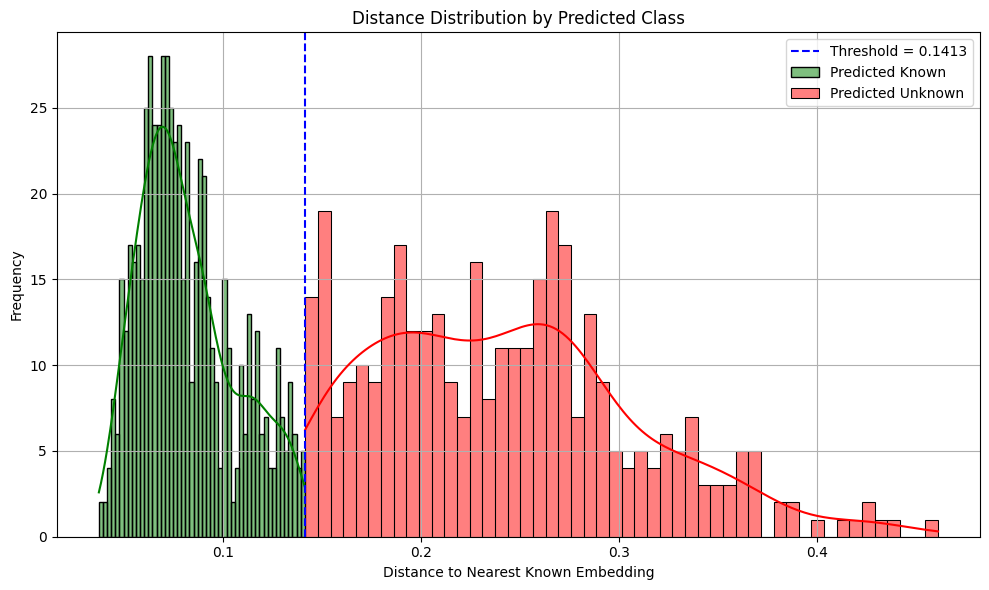

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(results_df[results_df['Predicted Class'] == 'Known']['Distance'],
             color='green', label='Predicted Known', kde=True, bins=50)
sns.histplot(results_df[results_df['Predicted Class'] == 'Unknown']['Distance'],
             color='red', label='Predicted Unknown', kde=True, bins=50)
plt.axvline(best_threshold, color='blue', linestyle='--', label=f'Threshold = {best_threshold:.4f}')
plt.title("Distance Distribution by Predicted Class")
plt.xlabel("Distance to Nearest Known Embedding")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/test_distance_histogram_detailed.png")
plt.show()


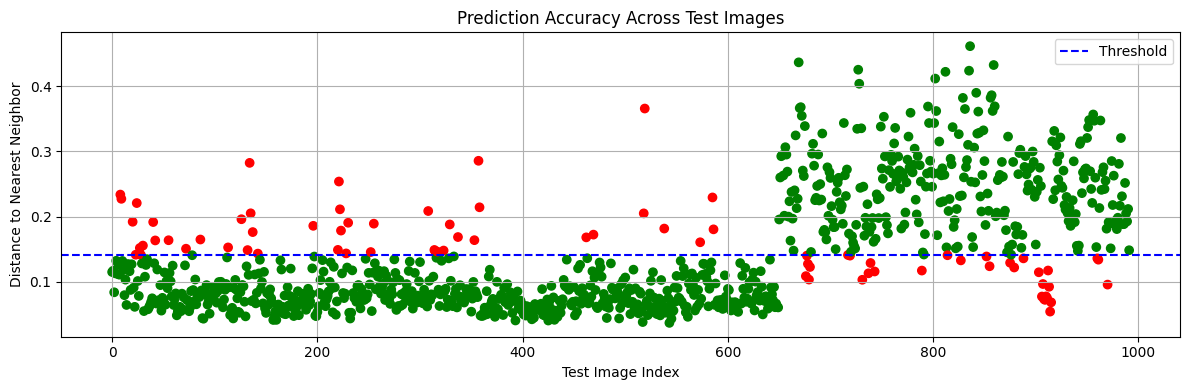

In [30]:
plt.figure(figsize=(12, 4))
colors = results_df['Correct?'].map({'✅': 'green', '❌': 'red'})
plt.scatter(range(len(results_df)), results_df['Distance'], c=colors)
plt.axhline(best_threshold, color='blue', linestyle='--', label='Threshold')
plt.title('Prediction Accuracy Across Test Images')
plt.xlabel('Test Image Index')
plt.ylabel('Distance to Nearest Neighbor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/test_accuracy_scatter.png")
plt.show()


In [31]:
accuracy = (results_df['Correct?'] == '✅').mean()
print(f"✅ دقت مدل روی مجموعه تست: {accuracy * 100:.2f}%")


✅ دقت مدل روی مجموعه تست: 91.94%


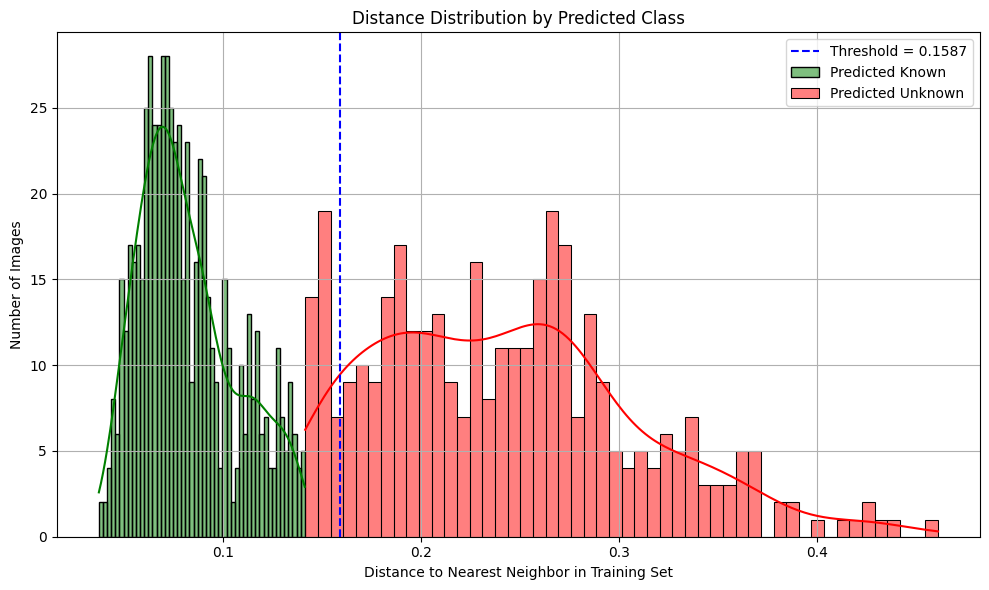

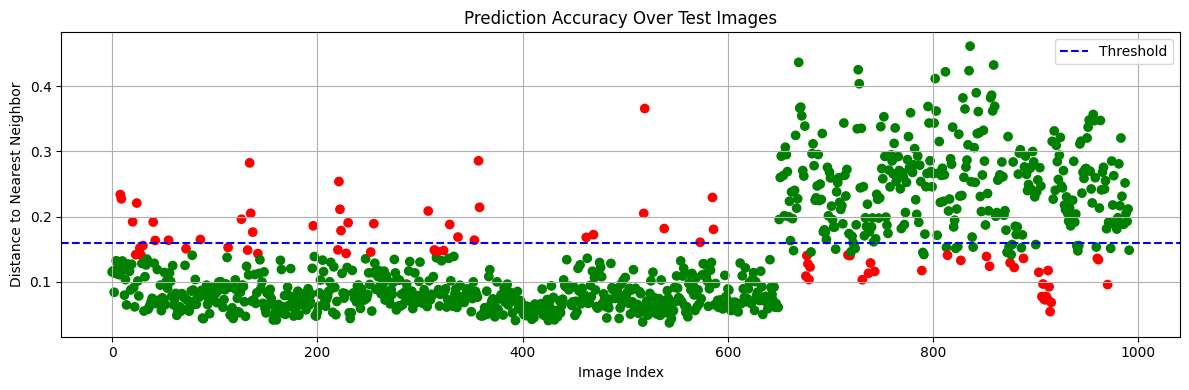


✅ Overall model accuracy on test set: 91.94%


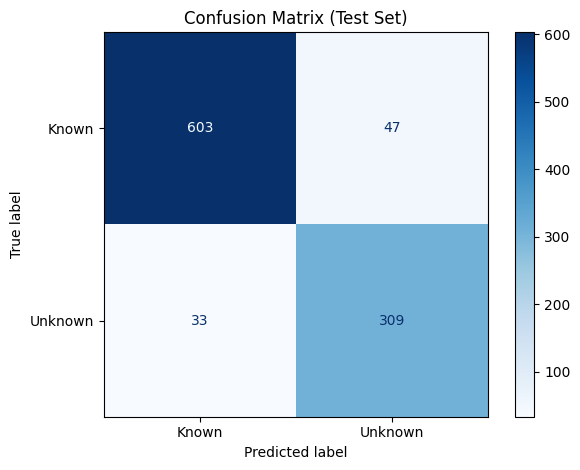

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load predictions from CSV
csv_path = "/content/drive/MyDrive/test_predictions_detailed.csv"
results_df = pd.read_csv(csv_path)

# Threshold (from validation step)
best_threshold = 0.1587  # update if needed

# Histogram of distances
plt.figure(figsize=(10, 6))
sns.histplot(results_df[results_df['Predicted Class'] == 'Known']['Distance'],
             color='green', label='Predicted Known', kde=True, bins=50)
sns.histplot(results_df[results_df['Predicted Class'] == 'Unknown']['Distance'],
             color='red', label='Predicted Unknown', kde=True, bins=50)
plt.axvline(best_threshold, color='blue', linestyle='--', label=f'Threshold = {best_threshold:.4f}')
plt.title("Distance Distribution by Predicted Class")
plt.xlabel("Distance to Nearest Neighbor in Training Set")
plt.ylabel("Number of Images")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/test_distance_histogram_detailed.png")
plt.show()

# Scatter plot of prediction correctness
plt.figure(figsize=(12, 4))
colors = results_df['Correct?'].map({'✅': 'green', '❌': 'red'})
plt.scatter(range(len(results_df)), results_df['Distance'], c=colors)
plt.axhline(best_threshold, color='blue', linestyle='--', label='Threshold')
plt.title('Prediction Accuracy Over Test Images')
plt.xlabel('Image Index')
plt.ylabel('Distance to Nearest Neighbor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/test_accuracy_scatter.png")
plt.show()

# Overall accuracy
accuracy = (results_df['Correct?'] == '✅').mean()
print(f"\n✅ Overall model accuracy on test set: {accuracy * 100:.2f}%")

# Confusion matrix
true_labels = results_df['Actual Class'].map({'Known': 0, 'Unknown': 1}).values
pred_labels = results_df['Predicted Class'].map({'Known': 0, 'Unknown': 1}).values

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Known', 'Unknown'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/test_confusion_matrix_from_csv.png")
plt.show()


In [12]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix
)

# Load the predictions CSV
csv_path = "/content/drive/MyDrive/test_predictions_detailed.csv"
df = pd.read_csv(csv_path)

# Convert textual labels to binary
y_true = df['Actual Class'].map({'Known': 0, 'Unknown': 1}).values
y_pred = df['Predicted Class'].map({'Known': 0, 'Unknown': 1}).values
y_scores = df['Distance'].values  # distances used as scores for ROC

# Calculate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores)
ap = average_precision_score(y_true, y_scores)

# Display metrics
print("📊 Evaluation Metrics on Test Set:")
print(f"✔️ Accuracy:             {acc:.4f}")
print(f"✔️ Precision:            {prec:.4f}")
print(f"✔️ Recall:               {rec:.4f}")
print(f"✔️ F1 Score:             {f1:.4f}")
print(f"✔️ ROC AUC Score:        {roc_auc:.4f}")
print(f"✔️ Average Precision:    {ap:.4f}")
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Known", "Unknown"]))

# Optional: Confusion Matrix
print("\n🔹 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)


📊 Evaluation Metrics on Test Set:
✔️ Accuracy:             0.9194
✔️ Precision:            0.8680
✔️ Recall:               0.9035
✔️ F1 Score:             0.8854
✔️ ROC AUC Score:        0.9637
✔️ Average Precision:    0.9356

📄 Classification Report:
              precision    recall  f1-score   support

       Known       0.95      0.93      0.94       650
     Unknown       0.87      0.90      0.89       342

    accuracy                           0.92       992
   macro avg       0.91      0.92      0.91       992
weighted avg       0.92      0.92      0.92       992


🔹 Confusion Matrix:
[[603  47]
 [ 33 309]]


##`here is for detecting the identity after detecting that a cattle is known`

✅ Using DEVICE = cpu.
✅ Model loaded successfully.

🔍 Finding the optimal threshold...


Extracting known DB embeddings: 100%|██████████| 35/35 [02:45<00:00,  4.72s/it]


✅ Optimal threshold found: 0.0066.


Evaluating Test Set: 100%|██████████| 992/992 [01:31<00:00, 10.83it/s]



✅ Detailed results saved to /content/drive/MyDrive/detect_id/test_predictions_detailed.csv.


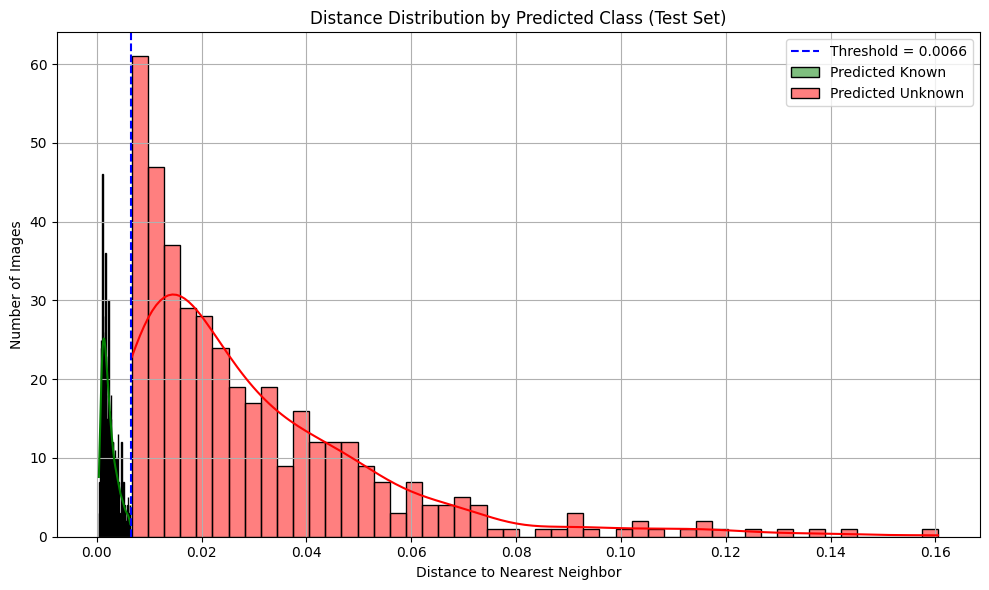

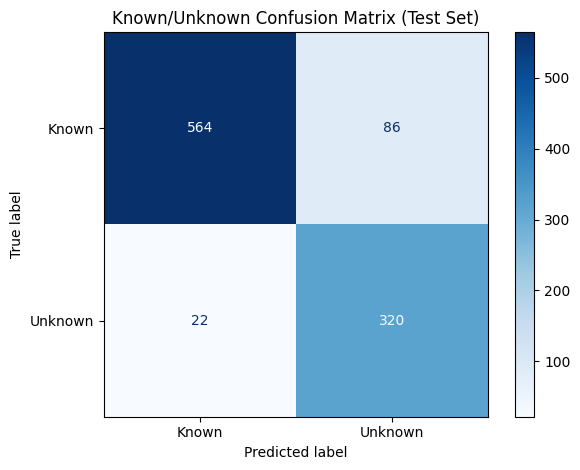


📄 Classification Report on Test Set:
              precision    recall  f1-score   support

       Known       0.96      0.87      0.91       650
     Unknown       0.79      0.94      0.86       342

    accuracy                           0.89       992
   macro avg       0.88      0.90      0.88       992
weighted avg       0.90      0.89      0.89       992


--- Predicted ID accuracy for known cows ---
✅ ID accuracy for known cows: 0.9590 or 95.90%
ℹ️ Out of 586 cases identified as 'Known', 562 had the correct ID.

--- Confusion Matrix for Predicted IDs (Known Cows Only) ---


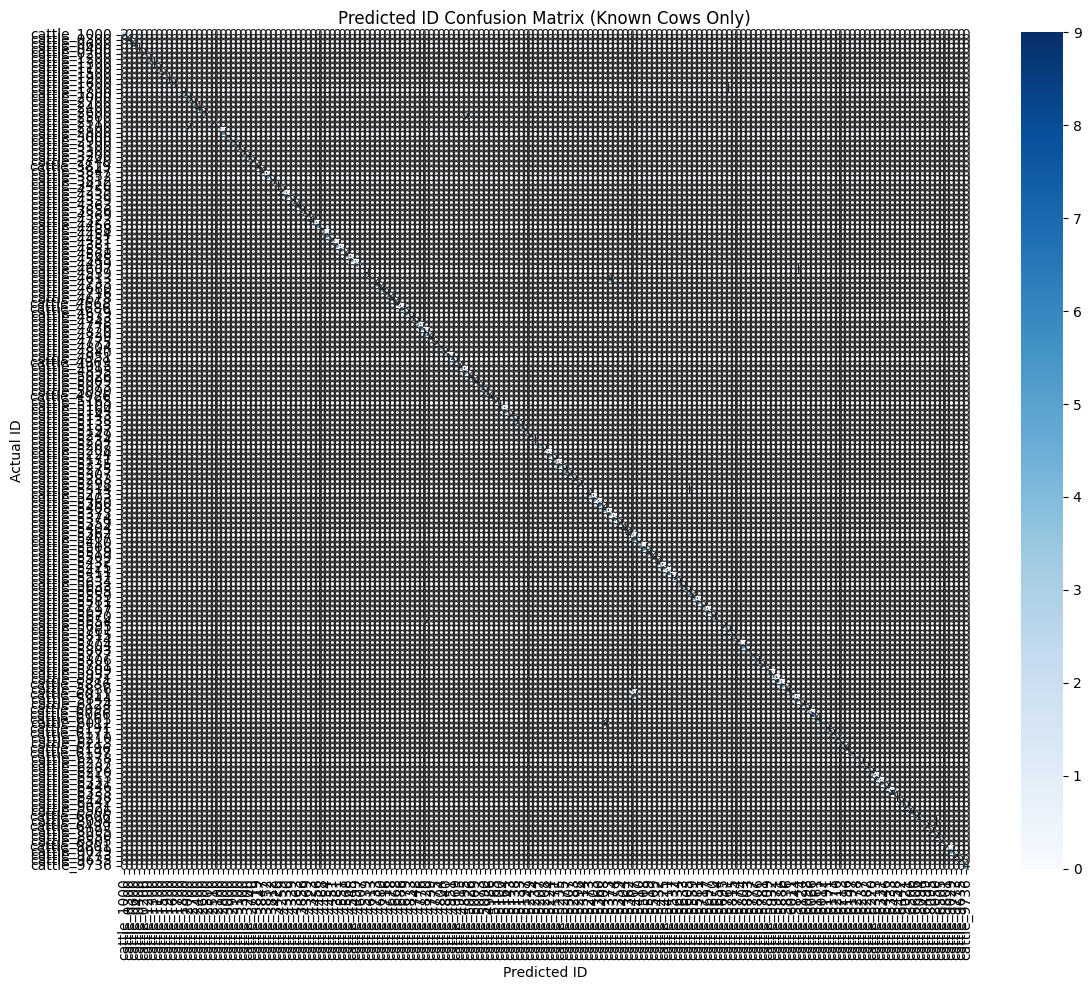

In [21]:
# ---------------------- Cell 1: Environment Setup and Model Loading ----------------------
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import resnet50, ResNet50_Weights
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2

# Define paths
DRIVE_PATH = '/content/drive/MyDrive'
CHECKPOINT_PATH = os.path.join(DRIVE_PATH, 'checkpoints', 'encoder_checkpoint_resnet.pth')
EMBEDDINGS_PATH = os.path.join(DRIVE_PATH, 'models', 'cow_embeddings.npz')
DATASET_JSON_PATH = os.path.join(DRIVE_PATH, 'dataset_paths.json')
OUTPUT_DIR = os.path.join(DRIVE_PATH, 'detect_id')
TEST_DIR = os.path.join(DRIVE_PATH, 'test')

# Create folders
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.dirname(EMBEDDINGS_PATH), exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using DEVICE = {device}.")

# Encoder and FeatureDataset Classes (from your notebook)
class Encoder(nn.Module):
    def __init__(self, embedding_dim=128, fine_tune_backbone=True):
        super(Encoder, self).__init__()
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.backbone = resnet50(weights=weights)
        self.backbone = torch.nn.Sequential(*list(self.backbone.children())[:-1])
        if not fine_tune_backbone:
             for param in self.backbone.parameters():
                 param.requires_grad = False
        self.embedding_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, embedding_dim)
        )
    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding_head(x)
        return x

class FeatureDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image

# Define transform for feature extraction
feature_transform = Compose([
    Resize(128, 128),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Load the trained model
try:
    model = Encoder(embedding_dim=128, fine_tune_backbone=True).to(device)
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please make sure the model file is in the correct path.")
    exit()

# ---------------------- Cell 2: Finding the Best Threshold ----------------------
print("\n🔍 Finding the optimal threshold...")
with open(DATASET_JSON_PATH, 'r') as f:
    paths = json.load(f)

# Known cow embeddings (Validation set)
known_val_paths = paths['known_val']
known_labels = [os.path.basename(os.path.dirname(path)) for path in known_val_paths]
known_val_dataset = FeatureDataset(known_val_paths, transform=feature_transform)
known_val_loader = DataLoader(known_val_dataset, batch_size=64, shuffle=False, num_workers=2)
known_embeddings_val = []
with torch.no_grad():
    for images in tqdm(known_val_loader, desc="Extracting known embeddings"):
        images = images.to(device)
        emb = model(images)
        known_embeddings_val.append(emb.cpu())
known_embeddings_val = torch.cat(known_embeddings_val).numpy()

# Unknown cow embeddings (Validation set)
unknown_val_paths = paths['unknown_val']
unknown_val_dataset = FeatureDataset(unknown_val_paths, transform=feature_transform)
unknown_val_loader = DataLoader(unknown_val_dataset, batch_size=64, shuffle=False, num_workers=2)
unknown_embeddings_val = []
with torch.no_grad():
    for images in tqdm(unknown_val_loader, desc="Extracting unknown embeddings"):
        images = images.to(device)
        emb = model(images)
        unknown_embeddings_val.append(emb.cpu())
unknown_embeddings_val = torch.cat(unknown_embeddings_val).numpy()

# Build the known embeddings database for evaluation
known_db_paths = paths['known_train']
known_db_labels = [os.path.basename(os.path.dirname(path)) for path in known_db_paths]
known_db_dataset = FeatureDataset(known_db_paths, transform=feature_transform)
known_db_loader = DataLoader(known_db_dataset, batch_size=64, shuffle=False, num_workers=2)
known_embeddings_db = []
with torch.no_grad():
    for images in tqdm(known_db_loader, desc="Extracting known DB embeddings"):
        images = images.to(device)
        emb = model(images)
        known_embeddings_db.append(emb.cpu())
known_embeddings_db = torch.cat(known_embeddings_db).numpy()
knn_db = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine')
knn_db.fit(known_embeddings_db)

# Calculate distances and find the best threshold
all_embeddings_val = np.concatenate([known_embeddings_val, unknown_embeddings_val])
all_labels_val = np.concatenate([np.ones(len(known_embeddings_val)), np.zeros(len(unknown_embeddings_val))])
distances, _ = knn_db.kneighbors(all_embeddings_val)
distances = distances.ravel()

fpr, tpr, thresholds = roc_curve(all_labels_val, distances, pos_label=0)

best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]

print(f"✅ Optimal threshold found: {best_threshold:.4f}.")

# ---------------------- Cell 3: Prediction on the entire Test folder ----------------------
if not os.path.exists(TEST_DIR):
    print(f"❌ Error: Test folder not found at path {TEST_DIR}.")
    exit()

all_test_paths = glob(os.path.join(TEST_DIR, '*', '*.jpg')) + glob(os.path.join(TEST_DIR, '*', '*.png'))
if not all_test_paths:
    print(f"⚠️ No images found in test folder {TEST_DIR}. Process stopped.")
    exit()

# Build the final known database from both train and validation sets
known_db_paths_final = paths['known_train'] + paths['known_val']
known_db_labels_final = [os.path.basename(os.path.dirname(path)) for path in known_db_paths_final]
known_db_dataset_final = FeatureDataset(known_db_paths_final, transform=feature_transform)
known_db_loader_final = DataLoader(known_db_dataset_final, batch_size=64, shuffle=False, num_workers=2)
known_embeddings_db_final = []
with torch.no_grad():
    for images in tqdm(known_db_loader_final, desc="Building Final Known Database"):
        images = images.to(device)
        emb = model(images)
        known_embeddings_db_final.append(emb.cpu())
known_embeddings_db_final = torch.cat(known_embeddings_db_final).numpy()

knn_final = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine')
knn_final.fit(known_embeddings_db_final)

results = []
for path in tqdm(all_test_paths, desc="Evaluating Test Set"):
    folder_name = os.path.basename(os.path.dirname(path))

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed_image = feature_transform(image=img)['image']

    with torch.no_grad():
        new_embedding = model(transformed_image.unsqueeze(0).to(device)).squeeze().cpu().numpy()

    distances, indices = knn_final.kneighbors(new_embedding.reshape(1, -1))
    min_distance = distances[0][0]

    # Your two-step logic
    if min_distance < best_threshold:
        predicted_class = "Known"
        predicted_id = known_db_labels_final[indices[0][0]]
    else:
        predicted_class = "Unknown"
        predicted_id = "N/A"

    actual_class = "Known" if folder_name in paths['known_classes'] else "Unknown"
    actual_id = folder_name

    correct_class_prediction = (predicted_class == actual_class)
    correct_id_prediction = (predicted_class == 'Unknown' and actual_class == 'Unknown') or \
                            (predicted_class == 'Known' and predicted_id == actual_id)

    results.append({
        "Image Path": path,
        "Actual_Class": actual_class,
        "Predicted_Class": predicted_class,
        "Actual_ID": actual_id,
        "Predicted_ID": predicted_id,
        "Min_Distance": round(min_distance, 4),
        "Correct_Class_Prediction": "✅" if correct_class_prediction else "❌",
        "Correct_ID_Prediction": "✅" if correct_id_prediction else "❌"
    })

results_df = pd.DataFrame(results)
csv_path = os.path.join(OUTPUT_DIR, 'test_predictions_detailed.csv')
results_df.to_csv(csv_path, index=False)
print(f"\n✅ Detailed results saved to {csv_path}.")

# ---------------------- Cell 4: Plotting and Final Results Display ----------------------
if 'results_df' in locals() and not results_df.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df[results_df['Predicted_Class'] == 'Known']['Min_Distance'],
                 color='green', label='Predicted Known', kde=True, bins=50)
    sns.histplot(results_df[results_df['Predicted_Class'] == 'Unknown']['Min_Distance'],
                 color='red', label='Predicted Unknown', kde=True, bins=50)
    plt.axvline(best_threshold, color='blue', linestyle='--', label=f'Threshold = {best_threshold:.4f}')
    plt.title("Distance Distribution by Predicted Class (Test Set)")
    plt.xlabel("Distance to Nearest Neighbor")
    plt.ylabel("Number of Images")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'test_distance_histogram.png'))
    plt.show()

    # Known/Unknown Confusion Matrix
    true_labels = results_df['Actual_Class'].map({'Known': 0, 'Unknown': 1}).values
    pred_labels = results_df['Predicted_Class'].map({'Known': 0, 'Unknown': 1}).values
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Known', 'Unknown'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Known/Unknown Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'test_known_unknown_confusion_matrix.png'))
    plt.show()

    print("\n📄 Classification Report on Test Set:")
    print(classification_report(true_labels, pred_labels, target_names=["Known", "Unknown"]))

    # Predicted ID accuracy for Known cows
    known_predictions_df = results_df[results_df['Predicted_Class'] == 'Known']
    if not known_predictions_df.empty:
        total_known_predictions = len(known_predictions_df)
        correct_id_predictions = (known_predictions_df['Actual_ID'] == known_predictions_df['Predicted_ID']).sum()
        accuracy_id_known = correct_id_predictions / total_known_predictions
        print("\n--- Predicted ID accuracy for known cows ---")
        print(f"✅ ID accuracy for known cows: {accuracy_id_known:.4f} or {accuracy_id_known * 100:.2f}%")
        print(f"ℹ️ Out of {total_known_predictions} cases identified as 'Known', {correct_id_predictions} had the correct ID.")
    else:
        print("\n⚠️ No cases were predicted as 'Known'. ID accuracy cannot be calculated.")

    # New Confusion Matrix for Predicted IDs (Known-only)
    if not known_predictions_df.empty and len(known_predictions_df['Actual_ID'].unique()) > 1:
        print("\n--- Confusion Matrix for Predicted IDs (Known Cows Only) ---")
        cm_id = confusion_matrix(known_predictions_df['Actual_ID'], known_predictions_df['Predicted_ID'],
                                 labels=known_predictions_df['Actual_ID'].unique())

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_id, annot=True, fmt='d', cmap='Blues',
                    xticklabels=known_predictions_df['Actual_ID'].unique(),
                    yticklabels=known_predictions_df['Actual_ID'].unique())
        plt.title('Predicted ID Confusion Matrix (Known Cows Only)')
        plt.ylabel('Actual ID')
        plt.xlabel('Predicted ID')
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'test_id_confusion_matrix_known_only.png'))
        plt.show()
    elif not known_predictions_df.empty:
        print("\n⚠️ Not enough unique 'Known' cow IDs to create a confusion matrix for IDs.")
    else:
        pass # Already handled in the previous block

else:
    print("❌ The results dataframe is empty. Please ensure the 'test' folder contains valid images.")

In [23]:
if 'results_df' in locals() and not results_df.empty:
    # 1. Create the 'Image Name' column from the full path
    results_df['Image Name'] = results_df['Image Path'].apply(lambda x: os.path.basename(x))

    # 2. Create the 'Actual Status' column based on the requested format
    results_df['Actual Status'] = results_df.apply(
        lambda row: f"Known (ID: {row['Actual_ID']})" if row['Actual_Class'] == 'Known' else 'Unknown',
        axis=1
    )

    # 3. Create the 'Model Prediction' column
    results_df['Model Prediction'] = results_df.apply(
        lambda row: f"Known (ID: {row['Predicted_ID']})" if row['Predicted_Class'] == 'Known' else 'Unknown',
        axis=1
    )

    # Create the final table with the specified columns
    final_table = results_df[['Image Name', 'Actual Status', 'Model Prediction']]

    # Print the table to the console
    print("\n--- Model Predictions Summary Table ---")
    print(final_table)

    # Optional: Save the table to a CSV file
    csv_path = os.path.join(OUTPUT_DIR, 'detailed_predictions_table.csv')
    final_table.to_csv(csv_path, index=False)
    print(f"\n✅ Detailed prediction table saved to {csv_path}.")

else:
    print("❌ The results dataframe is empty. Please ensure the 'test' folder contains valid images and the preceding code has been executed successfully.")


--- Model Predictions Summary Table ---
                   Image Name            Actual Status  \
0    cattle_1000_DSCF3961.jpg  Known (ID: cattle_1000)   
1    cattle_1000_DSCF3965.jpg  Known (ID: cattle_1000)   
2    cattle_1000_DSCF3966.jpg  Known (ID: cattle_1000)   
3    cattle_0100_DSCF3860.jpg                  Unknown   
4    cattle_0100_DSCF3866.jpg                  Unknown   
..                        ...                      ...   
987  cattle_9634_DSCF8589.jpg                  Unknown   
988  cattle_9634_DSCF8590.jpg                  Unknown   
989  cattle_9634_DSCF8594.jpg                  Unknown   
990  cattle_9634_DSCF8600.jpg                  Unknown   
991  cattle_9634_DSCF8610.jpg                  Unknown   

            Model Prediction  
0    Known (ID: cattle_1000)  
1                    Unknown  
2    Known (ID: cattle_1000)  
3                    Unknown  
4                    Unknown  
..                       ...  
987                  Unknown  
988           

In [24]:
if 'results_df' in locals() and not results_df.empty:

    # ------------------ تحلیل تفکیک Known/Unknown ------------------
    print("--- Analysis of Known/Unknown Classification ---\n")

    # Total number of images
    total_images = len(results_df)

    # Get actual and predicted classes
    actual_classes = results_df['Actual_Class']
    predicted_classes = results_df['Predicted_Class']

    # Calculate classification report
    report = classification_report(actual_classes, predicted_classes, output_dict=True)

    # Extract key metrics
    known_precision = report['Known']['precision']
    known_recall = report['Known']['recall']
    unknown_precision = report.get('Unknown', {}).get('precision', 0)
    unknown_recall = report.get('Unknown', {}).get('recall', 0)
    accuracy = report['accuracy']

    # Print the summary
    print(f"✅ Overall Accuracy: {accuracy:.2%} of all images were classified correctly as Known or Unknown.")
    print("-" * 50)
    print("For Known Cows (شناخته‌شده):")
    print(f"  - Precision: {known_precision:.2%} -> Of all cows predicted as Known, this many were actually Known.")
    print(f"  - Recall: {known_recall:.2%} -> Of all cows that were actually Known, this many were correctly identified.")
    print("\nFor Unknown Cows (ناشناخته):")
    print(f"  - Precision: {unknown_precision:.2%} -> Of all cows predicted as Unknown, this many were actually Unknown.")
    print(f"  - Recall: {unknown_recall:.2%} -> Of all cows that were actually Unknown, this many were correctly identified.")

    # ------------------ تحلیل دقت پیش‌بینی آیدی ------------------
    known_predictions_df = results_df[results_df['Predicted_Class'] == 'Known']

    print("\n\n--- Analysis of ID Prediction Accuracy (for Known Cows) ---")
    if not known_predictions_df.empty:
        total_known_predictions = len(known_predictions_df)
        correct_id_predictions = (known_predictions_df['Actual_ID'] == known_predictions_df['Predicted_ID']).sum()
        accuracy_id_known = correct_id_predictions / total_known_predictions

        print(f"✅ ID Prediction Accuracy: {accuracy_id_known:.2%} or {correct_id_predictions} out of {total_known_predictions} correct predictions.")
    else:
        print("⚠️ No cows were predicted as 'Known', so ID accuracy cannot be calculated.")

    # ------------------ خلاصه موارد اشتباه ------------------
    print("\n\n--- Summary of Model Errors ---")

    # False Positives (Unknown predicted as Known)
    false_positives = results_df[(results_df['Actual_Class'] == 'Unknown') & (results_df['Predicted_Class'] == 'Known')]
    print(f"❌ False Positives (Type I Error): {len(false_positives)} cows were actually 'Unknown' but predicted as 'Known'.")
    if not false_positives.empty:
        print("  - These are new cows that the model mistook for an existing cow.")
        print(false_positives[['Image Name', 'Predicted_ID']].head())

    # False Negatives (Known predicted as Unknown)
    false_negatives = results_df[(results_df['Actual_Class'] == 'Known') & (results_df['Predicted_Class'] == 'Unknown')]
    print(f"❌ False Negatives (Type II Error): {len(false_negatives)} cows were actually 'Known' but predicted as 'Unknown'.")
    if not false_negatives.empty:
        print("  - These are existing cows that the model failed to recognize.")
        print(false_negatives[['Image Name', 'Actual_ID']].head())

else:
    print("❌ The results dataframe is empty. Please ensure the 'test' folder contains valid images and the preceding code has been executed successfully.")

--- Analysis of Known/Unknown Classification ---

✅ Overall Accuracy: 89.11% of all images were classified correctly as Known or Unknown.
--------------------------------------------------
For Known Cows (شناخته‌شده):
  - Precision: 96.25% -> Of all cows predicted as Known, this many were actually Known.
  - Recall: 86.77% -> Of all cows that were actually Known, this many were correctly identified.

For Unknown Cows (ناشناخته):
  - Precision: 78.82% -> Of all cows predicted as Unknown, this many were actually Unknown.
  - Recall: 93.57% -> Of all cows that were actually Unknown, this many were correctly identified.


--- Analysis of ID Prediction Accuracy (for Known Cows) ---
✅ ID Prediction Accuracy: 95.90% or 562 out of 586 correct predictions.


--- Summary of Model Errors ---
❌ False Positives (Type I Error): 22 cows were actually 'Unknown' but predicted as 'Known'.
  - These are new cows that the model mistook for an existing cow.
                   Image Name Predicted_ID
51   c

In [26]:
if 'results_df' in locals() and not results_df.empty:

    # Filter results for cows that the model predicted as "Known"
    known_predictions_df = results_df[results_df['Predicted_Class'] == 'Known'].copy()

    if not known_predictions_df.empty:
        total_known_predictions = len(known_predictions_df)

        # Count the number of correct ID predictions
        correct_id_predictions = (known_predictions_df['Actual_ID'] == known_predictions_df['Predicted_ID']).sum()

        # Calculate the accuracy percentage
        accuracy_id_known = correct_id_predictions / total_known_predictions

        print("\n--- Predicted ID accuracy for known cows ---")
        print(f"✅ ID accuracy for known cows: {accuracy_id_known:.4f} or {accuracy_id_known * 100:.2f}%")
        print(f"ℹ️ Out of a total of {total_known_predictions} cases identified as Known, {correct_id_predictions} had the correct ID.")
    else:
        print("\n⚠️ No cases were predicted as 'Known'. ID accuracy cannot be calculated.")

else:
    print("❌ The results dataframe (results_df) is empty. Please ensure you have executed the main prediction code.")


--- Predicted ID accuracy for known cows ---
✅ ID accuracy for known cows: 0.9590 or 95.90%
ℹ️ Out of a total of 586 cases identified as Known, 562 had the correct ID.
